# COMP30027 Machine Learning Assignment 2

### Project 2: How long does it take to cook this? 
**Task:** Build a classifier to predict cooking time of recipes

**Author:** Tuan Khoi Nguyen - 1025294. 
Hai Hong Tran    - 1012919

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os
import pandas as pd
import numpy as np
import re
import time
import pickle

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets, svm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectPercentile, SelectFpr, chi2, mutual_info_classif
from sklearn.model_selection import cross_val_score

from tqdm import tqdm,trange
from collections import defaultdict,Counter
from text2digits import text2digits

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

## Part 0: Data preprocessing method selection

In [2]:
def preprocess(file, 
               process = None, 
               convert_to_seconds = False):
    curr_dir = os.path.dirname(os.path.realpath('__file__'))
    if not process:
        train_file = os.path.join(curr_dir, 'COMP30027_2021_Project2_datasets\\'+file)
    else:
        train_file = os.path.join(curr_dir, 'COMP30027_2021_Project2_datasets\\recipe_text_features_' + process + '\\' + file)

    data = pd.read_csv(train_file, index_col = False, delimiter = ',')
    if convert_to_seconds:
        tqdm.pandas(desc="Converting...")
        data['seconds'] = data['steps'].progress_apply(convert_step_to_time)
    return data

In [18]:
def read_pkl_file(files_name):
    file_paths = []
    for file_name in files_name:
        curr_dir = os.path.dirname(os.path.realpath('__file__'))
        file_paths.append(os.path.join(curr_dir, 'COMP30027_2021_Project2_datasets\\recipe_text_features_countvec\\', file_name))
    
    name = pickle.load(open(file_paths[0], "rb"))
    ingr = pickle.load(open(file_paths[1], "rb"))
    steps = pickle.load(open(file_paths[2], "rb"))
    return name, ingr, steps


def read_npz_file(files_name, use_scipy = True):
    file_paths = []
    for file_name in files_name:
        curr_dir = os.path.dirname(os.path.realpath('__file__'))
        file_paths.append(os.path.join(curr_dir, 'COMP30027_2021_Project2_datasets\\recipe_text_features_countvec\\' , file_name))
    
    if use_scipy:
        names = scipy.sparse.load_npz(file_paths[0])
        ingr = scipy.sparse.load_npz(file_paths[1])
        steps = scipy.sparse.load_npz(file_paths[2])
        return names, ingr, steps
    
    npz_names = np.load(file_paths[0])
    names = pd.DataFrame.from_dict({i: npz_names[i] for i in npz_names.files}, orient='index')

    npz_ingr = np.load(file_paths[1])
    ingr = pd.DataFrame.from_dict({i: npz_ingr[i] for i in npz_ingr.files}, orient='index')

    npz_steps = np.load(file_paths[2])
    steps = pd.DataFrame.from_dict({i: npz_steps[i] for i in npz_steps.files}, orient='index')
    return names,ingr,steps

def read_train_file(preprocess_method, files_name):
    file_paths = []
    for file_name in files_name:
        curr_dir = os.path.dirname(os.path.realpath('__file__'))
        file_paths.append(os.path.join(curr_dir, 'COMP30027_2021_Project2_datasets\\', preprocess_method, file_name))
    
    names = pd.read_csv(file_paths[0], index_col = False, delimiter = ',', header=None)
    ingr = pd.read_csv(file_paths[1], index_col = False, delimiter = ',', header=None)
    steps = pd.read_csv(file_paths[2], index_col = False, delimiter = ',', header=None)
    
    return names, ingr, steps

In [5]:
time_retrieval = lambda words, sentence : re.findall(re.compile('|'.join(
        [n + w + "\\b" for w in words for n in ["[0-9]+\s*","another ","few ","a ","an ","several "]])), sentence)

kw_retrieval = lambda words, sentence : re.findall(re.compile('|'.join(
        ["\\b" + w + "\\b" for w in words])), sentence)

def convert_step_to_time(step, keyword_check = True):
    t2d = text2digits.Text2Digits()
    total_time = 0 # in seconds
    times = defaultdict(list)
    time_unit = {"second":1, "minute":60, "hour":60*60}
    kw_dict = {"overnight":8, "night":8, "nights":8, "freeze":5, "refrigerate":3,
               "day":12, "cook on low":7, "slow cook":7, "crockpot":7, "crock pot":7,
               "cook low":7, "boil":1, "heat":1, "bread machine":1.5
               }
    
    # Iterate through each step to find time value using RE
    numeric_step = t2d.convert(step)
    times["second"] = time_retrieval(["more seconds","more second","more secs","more sec","seconds","second","secs","sec","s"],numeric_step)
    times["minute"] = time_retrieval(["more minutes","more minute","more min","more mins","minutes","minute","min","mins","m","ms"],numeric_step)
    times["hour"] = time_retrieval(["more hours","more hour","more hrs","more hr","hours","hour","hrs","hr","h","hs"],numeric_step)
    special_keywords = kw_retrieval(kw_dict.keys(),numeric_step) if keyword_check else None

    for unit in time_unit.keys():
        #total_time += sum([float(re.findall(r'[0-9]+',t.split()[0])[0]) * time_unit[unit] for t in times[unit]])
        count = 0
        for t in times[unit]:
            numerator = t.split()[0]

            if numerator in ["another","a","an"]:
                count = 1
            elif numerator in ["few","several"]:
                count = 4
            else:
                count = float(re.findall(r'[0-9]+',numerator)[0])

            total_time += count * time_unit[unit]

    if keyword_check and not total_time and special_keywords:
        total_time += 60*60*kw_dict[special_keywords[0]]

    if total_time == 0:
        return None
    return total_time

In [36]:
kw_dict = {"overnight":8, "night":8, "nights":8, "refrigerate":4,
            "day":12, "freeze":6, "cook on low":7, "slow cook":7,
            "cook low":7, "bread machine":7, "boil":1, "heat":1.5}
kw_retrieval(kw_dict.keys(),'freeze overnight then put to boil')   
kw_dict.values()         

dict_values([8, 8, 8, 4, 12, 6, 7, 7, 7, 7, 1, 1.5])

### Read given preprocessed text input

Run each code cell below for specified file to be read

**Count vectorizer**

In [33]:
name, ingr, steps = read_npz_file(['train_name_vec.npz', 'train_ingr_vec.npz', 'train_steps_vec.npz'])
#print(steps)
steps[((0,584))]

1

In [28]:
npz = np.load('COMP30027_2021_Project2_datasets\\recipe_text_features_countvec\\train_steps_vec.npz')
print(npz.files)
npz['format']
pd.DataFrame.from_dict({i: npz[i] for i in ['indices', 'indptr', 'data']})

['indices', 'indptr', 'format', 'shape', 'data']


,0,1,2,3,4,5,6,7,8,9,...,1737811,1737812,1737813,1737814,1737815,1737816,1737817,1737818,1737819,1737820
indices,584,1172,2473.0,2726.0,2783.0,3248.0,3354.0,3554.0,4007.0,4442.0,...,12331.0,13008.0,13626.0,13636.0,14293.0,14582.0,15176.0,15265.0,16105.0,16107.0
indptr,0,30,71.0,123.0,162.0,184.0,239.0,273.0,364.0,388.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shape,40000,17967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
data,1,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [29]:
Counter(npz['data'])

Counter({1: 1398228,
         3: 63583,
         2: 238407,
         4: 22181,
         6: 3528,
         5: 8498,
         10: 186,
         15: 20,
         7: 1620,
         8: 821,
         9: 421,
         11: 114,
         12: 92,
         18: 7,
         14: 37,
         24: 3,
         13: 41,
         20: 2,
         19: 3,
         17: 5,
         22: 2,
         16: 7,
         21: 2,
         29: 1,
         39: 1,
         25: 1,
         30: 1,
         188: 1,
         28: 5,
         35: 1,
         32: 1,
         23: 1})

In [28]:
curr_dir = os.path.dirname(os.path.realpath('__file__'))
train_file = os.path.join(curr_dir, 'COMP30027_2021_Project2_datasets\\recipe_train.csv')

data = pd.read_csv(train_file, index_col = False, delimiter = ',')
y = data['duration_label']

k = 15
name, ingr, steps = read_pkl_file(['train_name_countvectorizer.pkl', 'train_ingr_countvectorizer.pkl', 'train_steps_countvectorizer.pkl'])
x2 = SelectKBest(chi2, k=k)

def feature_evaluation_countvec(X, k):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=30027)

    X_train_x2 = x2.fit_transform(X_train,y_train)
    X_test_x2 = x2.transform(X_test)

    models = [GaussianNB(),
              MultinomialNB(),
              DecisionTreeClassifier(max_depth=1),
              KNeighborsClassifier(n_neighbors=1),
              KNeighborsClassifier(n_neighbors=5),
              DecisionTreeClassifier(max_depth=None)]
#             svm.LinearSVC(C=C),
#             svm.SVC(kernel='rbf', gamma=0.7, C=C),
#             svm.SVC(kernel='poly', degree=3, C=C)]
    titles = ['GNB',
              'MNB',
              'one-r',
              '1-nearest neighbour',
              '5-nearest neighbour',
              'Decision Tree']
#             'LinearSVC',
#             'SVM with a cubic kernel',
#             'SVM with an RBF kernel']

    for title, model in zip(titles, models):
        print('\n',title, '(with k=',k,'features):')
    
        # x2
        start = time.time()
        model.fit(X_train_x2.todense(), y_train)
        acc = model.score(X_test_x2.todense(), y_test)
        end = time.time()
        t = end - start
        print("x2 \t\t accuracy:",acc, '\t runtime:', t)
        
#X_name = name.fit_transform(data['name'])
print('\nEvaluating Feature \'name\'')
feature_evaluation_countvec(name.fit_transform(data['name']), k)
      
print('\n\nEvaluating Feature \'ingredients\'')
feature_evaluation_countvec(ingr.fit_transform(data['ingredients']), k)
      
print('\n\nEvaluating Feature \'steps\'')
feature_evaluation_countvec(steps.fit_transform(data['steps']), k)


c:\python38\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.21.3 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(



Evaluating Feature 'name'

 GNB (with k= 15 features):
x2 		 accuracy: 0.51425 	 runtime: 0.028924226760864258

 MNB (with k= 15 features):
x2 		 accuracy: 0.55425 	 runtime: 0.015995264053344727

 one-r (with k= 15 features):
x2 		 accuracy: 0.5225 	 runtime: 0.010970115661621094

 1-nearest neighbour (with k= 15 features):
x2 		 accuracy: 0.51925 	 runtime: 6.0777504444122314

 5-nearest neighbour (with k= 15 features):
x2 		 accuracy: 0.5505 	 runtime: 6.084768533706665

 Decision Tree (with k= 15 features):
x2 		 accuracy: 0.55825 	 runtime: 0.037899017333984375

Evaluating Feature 'ingredients'

 GNB (with k= 15 features):
x2 		 accuracy: 0.5625 	 runtime: 0.03790020942687988

 MNB (with k= 15 features):
x2 		 accuracy: 0.527 	 runtime: 0.020946502685546875

 one-r (with k= 15 features):
x2 		 accuracy: 0.537 	 runtime: 0.014960765838623047

 1-nearest neighbour (with k= 15 features):
x2 		 accuracy: 0.552 	 runtime: 3.0578250885009766

 5-nearest neighbour (with k= 15 features):

**doc2vec50**

In [20]:
files_name = ['train_name_doc2vec50.csv', 'train_ingr_doc2vec50.csv', 'train_steps_doc2vec50.csv']
name, ingr, steps = read_train_file('recipe_text_features_doc2vec50\\', files_name)

X = [name, ingr, steps]
i = 0
for x in X:
    if i == 0:
        print('Evaluating on Name Feature:')
    elif i == 1:
        print('Evaluating on Ingredient Feature:')
    else:
        print('Evaluating on Steps Feature:')
        
    models = [DummyClassifier(strategy='most_frequent'),
              GaussianNB(),
              LinearSVC(),
              DecisionTreeClassifier(),
              KNeighborsClassifier(),
              LogisticRegression()]

    titles = ['Zero-R',
              'GNB',
              'LinearSVC',
              'Decision Tree',
              'KNN',
              'Logistic Regression']

    for title, model in zip(titles, models):
        start = time.time()
        acc = np.mean(cross_val_score(model, x, y, cv=10))
        end = time.time()
        t = end - start
        print(title, "Accuracy:",acc, '\tRuntime:', t)
    print()
    i = i + 1

Evaluating on Name Feature:
Zero-R Accuracy: 0.5061500000000001 	Runtime: 0.2124335765838623
GNB Accuracy: 0.5792750000000001 	Runtime: 0.7420146465301514


KeyboardInterrupt: 

**doc2vec100**

In [103]:
files_name = ['train_name_doc2vec100.csv', 'train_ingr_doc2vec100.csv', 'train_steps_doc2vec100.csv']
name, ingr, steps = read_train_file('recipe_text_features_doc2vec100\\', files_name)

X = [name, ingr, steps]
i = 0
for x in X:
    if i == 0:
        print('Evaluating on Name Feature:')
    elif i == 1:
        print('Evaluating on Ingredient Feature:')
    else:
        print('Evaluating on Steps Feature:')
        
    models = [DummyClassifier(strategy='most_frequent'),
              GaussianNB(),
              LinearSVC(),
              DecisionTreeClassifier(),
              KNeighborsClassifier(),
              LogisticRegression()]

    titles = ['Zero-R',
              'GNB',
              'LinearSVC',
              'Decision Tree',
              'KNN',
              'Logistic Regression']

    for title, model in zip(titles, models):
        start = time.time()
        acc = np.mean(cross_val_score(model, x, y, cv=10))
        end = time.time()
        t = end - start
        print(title, "Accuracy:",acc, '\tRuntime:', t)
    print()
    i = i + 1

Evaluating on Name Feature:
Zero-R Accuracy: 0.5061500000000001 	Runtime: 0.3071775436401367
GNB Accuracy: 0.5730749999999999 	Runtime: 1.132969617843628
LinearSVC Accuracy: 0.607325 	Runtime: 188.9464361667633
Decision Tree Accuracy: 0.492225 	Runtime: 64.57338762283325
KNN Accuracy: 0.576975 	Runtime: 41.29353332519531


c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

Logistic Regression Accuracy: 0.6096000000000001 	Runtime: 19.49396586418152

Evaluating on Ingredient Feature:
Zero-R Accuracy: 0.5061500000000001 	Runtime: 0.34408068656921387
GNB Accuracy: 0.54725 	Runtime: 1.42818284034729


c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\py

LinearSVC Accuracy: 0.58235 	Runtime: 423.3654956817627
Decision Tree Accuracy: 0.49355000000000004 	Runtime: 73.16237497329712
KNN Accuracy: 0.5379500000000002 	Runtime: 40.18614101409912
Logistic Regression Accuracy: 0.5824499999999999 	Runtime: 16.332329750061035

Evaluating on Steps Feature:
Zero-R Accuracy: 0.5061500000000001 	Runtime: 0.28224611282348633
GNB Accuracy: 0.603275 	Runtime: 1.347395896911621


c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\py

LinearSVC Accuracy: 0.6658000000000001 	Runtime: 424.7097158432007
Decision Tree Accuracy: 0.53675 	Runtime: 76.39373779296875
KNN Accuracy: 0.57255 	Runtime: 35.4543981552124


c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

Logistic Regression Accuracy: 0.6700000000000002 	Runtime: 18.288459539413452



### Creative text preprocessing method
Idea: Find all time-related content in 'steps' feature using Regular Expression. Sum the times up for total time and use that as a feature in training and classifying

In [196]:
# test function
#convert_step_to_time('3hrs and 10 hrs and 3 hours')
#re.findall(r"[0-9]+\s*hours\b|[0-9]+\s*hrs\b",'1hrs and 20 hrs and 3 hours and 4 halves and 5h and 6h, and 7h. 8house')
#re.findall(r"[0-9]+\s*hours\b|[0-9]+\s*hour\b|[0-9]+\s*hrs\b|[0-9]+\s*hr\b|[0-9]+\s*h\b|[0-9]+\s*hs\b",'1hrs and 20 hrs and 3 hours and 4 halves and 5h and 6h, and 7h. 8house')
#re.findall(r"[0-9]+\s*s[(ec+)\s\,\;\.]",'1s and 20 sec and 3sec and 4 sex and 5se and 6s, and 7se.')
#re.findall(r"s(ec+)",'1s and 20 sec and 3sec and 4 sex and 5se and 6s, and 7se.')
#re.findall(r"[0-9]+\s*"+"hours\b",'1hrs and 20 hrs and 3 hours and 4 halves and 5h and 6h, and 7h. 8house')
#re.findall(re.compile(''.join(["[0-9]", "\s*", "house"])), "1 house,2house")
#re.findall(re.compile('|'.join(["[0-9]+\s*" + word + "\\b" for word in ["hours","hour","hrs","hr","h"]])), '1hrs and 20 hrs and 3 hours and 4 halves and 5h and 6h, and 7h. 8house')
time_retrieval(["hours","hour","hrs","hr","h"],'1hrs and 20 hrs and 3 hours and 4 halves and 5h and 6h, and 7h. 8house')

['1hrs', '20 hrs', '3 hours', '5h', '6h', '7h']

In [6]:
data = preprocess('recipe_train.csv', convert_to_seconds=True)
data.sample(20)

Converting...: 100%|██████████| 40000/40000 [01:38<00:00, 407.84it/s]


,name,n_steps,n_ingredients,steps,ingredients,duration_label,seconds
402,spinach and ricotta calzone,25,14,"['dough', 'in a small mixing bowl , whisk toge...","['flour', 'frozen chopped spinach', 'whole mil...",2.0,11280.0
32324,greek spice rub or salad dressing,6,6,"['mix', 'store in airtight container', 'to use...","['oregano', 'dried mint', 'ground cumin', 'gro...",1.0,18000.0
35,zucchini and corn muffins,7,9,"['pre heat oven to 200 c', 'lightly grease 12 ...","['plain flour', 'cornmeal', 'sugar', 'baking p...",1.0,1200.0
39516,yummy beet salad with raspberry dressing,7,6,['cut the tops off the beets and boil whole be...,"['beets', 'mandarin oranges', 'vinaigrette', '...",1.0,1200.0
12524,make ahead cheese enchilada casserole,13,15,"['mix monterey jack cheese , cheddar cheese , ...","['monterey jack cheese', 'cheddar cheese', 'on...",2.0,1500.0
26879,duck sauce,3,5,"['add ingredients to a small sauce pan', 'cook...","['applesauce', 'apricot preserves', 'honey', '...",1.0,3600.0
12883,rib eye steaks with dijon gremolata,13,9,['heat gas grill on medium-high or charcoal gr...,"['rib eye steaks', 'seasoning salt', 'fresh gr...",1.0,3600.0
29529,breadfruit vichyssoise,9,9,"['heat the butter in a large saucepan', 'add t...","['butter', 'onions', 'garlic clove', 'breadfru...",2.0,3600.0
2012,easy breakfast sausage patties,6,11,['soak bread in milk in a large bowl for 5 min...,"['white bread', 'milk', 'oil', 'onion', 'groun...",2.0,4200.0
27735,black bean stuffed bell peppers,7,6,"['preheat oven to 350f', 'in large bowl , mix ...","['bell peppers', 'onion', 'cooked brown rice',...",2.0,1800.0


In [7]:
test_data = preprocess('recipe_test.csv', convert_to_seconds=True)
test_data.sample(20)

Converting...: 100%|██████████| 10000/10000 [00:25<00:00, 397.25it/s]


,name,n_steps,n_ingredients,steps,ingredients,seconds
8421,the creamiest macaroni and cheese,8,13,"['in a large heavy saucepan , bring milk , wat...","['milk', 'water', 'onion', 'salt', 'macaroni',...",2400.0
4374,barefoot contessa brownie pudding,13,7,"['preheat oven to 325 degrees', 'melt butter a...","['unsalted butter', 'extra large eggs', 'sugar...",3900.0
5979,rich chicken alfredo,18,10,['place salad dressing in a small resealable p...,"['italian salad dressing', 'boneless skinless ...",900.0
2454,deluxe pecan chocolate chip cookies,13,10,"['preheat oven to 375 degrees', 'in a small bo...","['all-purpose flour', 'baking soda', 'salt', '...",900.0
3776,chicken avocado melt,13,14,['place the chicken breasts between 2 sheets o...,"['chicken breast halves', 'cornstarch', 'groun...",1020.0
654,fantakuchen fanta cake a popular german cake...,11,13,"['for the cake: mix together the eggs , sugar ...","['eggs', 'sugar', 'flour', 'oil', 'orange', 'o...",2700.0
4126,everything and then some chocolate chip cookies,8,14,"['cream butter , oil , and sugars', 'add egg a...","['butter', 'oil', 'sugar', 'brown sugar', 'egg...",600.0
9217,bolognese sauce,10,18,['in a large dutch oven saute beef over med-hi...,"['lean ground beef', 'fennel seed', 'bacon', '...",6360.0
102,apple pie in cheddar crust,21,10,"['cheddar crust:', 'combine the flour , cheese...","['unbleached flour', 'cheddar cheese', 'salt',...",3000.0
8531,taco toast,8,4,"['pre heat oven 350', 'melt butter and stir in...","['texas toast thick bread', 'butter', 'taco se...",540.0


In [55]:
print(np.mean(data.loc[data['duration_label']==1.0]['seconds']))
print(np.mean(data.loc[data['duration_label']==2.0]['seconds']))
print(np.mean(data.loc[data['duration_label']==3.0]['seconds']))
data['steps'].iloc[39995]

3868.6148775189154
4546.9969594080985
28783.782587309393


'[\'in a measuring cup , combine sour cream and lemon juice\', \'add enough of the milk to make 1 / 2 cup\', "place all bread ingredients in bread machine according to your manufacturer\'s directions", \'select sweet bread or basic setting\', \'do not use timer delay for this recipe\', \'for spread , beat all ingredients together until smooth\']'

In [109]:
# Evaluate this new feature
train_data = data.loc[:,['n_steps','n_ingredients','seconds','steps','duration_label']]

# Why is the time missing?
missing_time_data = train_data.loc[np.isnan(train_data['seconds'])]
print(Counter(missing_time_data['duration_label']))

# How did the steps for different lengths look like, given that no timing is found?
long_missing = missing_time_data.loc[missing_time_data['duration_label']==3, ['steps']]
#long_missing.head(10)
[[print(s) for s in long_missing.iloc[i]] for i in range(10)]

Counter({1.0: 4356, 2.0: 513, 3.0: 16})
['cook on light cycle in your bread maker machine']
['for the artichoke hearts i have used either the jarred marinated or frozen hearts-thawed', 'make the cocktail dressing first by combining the mayonnaise , chili sauce , parsley , worcestershire , and black pepper', 'cover and chill', 'cut grapefruits in half', 'remove the fruit segments with a serrated spoon', 'cut the fruit segments up into bite sized pieces and toss with the lemon juice', 'clean out the grapefruit shells and remove pith', 'set aside', 'in a bowl gently mix the grapefruit , shrimp , cayenne and rum', 'cut the marinated artichokes up into bite sized pieces and combine with the grapefruit / shrimp mixture', 'if using frozen artichoke hearts , squeeze out the excess moisture gently with your hands', 'divide the mixture and spoon into the grapefruit shells', 'divide and spoon the cocktail dressing on top of each grapefruit shell', 'garnish with lemon slices and fresh parsley', 's

[[None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None]]

In [13]:
# We'll fix it later. For now, let's try and predict with the existing values first
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer


train_data = data.loc[np.isnan(data['seconds']) == False,['n_steps','n_ingredients','seconds','duration_label']]
Xseconds = data.loc[np.isnan(data['seconds']) == False,['seconds']]
X=train_data.iloc[:,:-1]
Y=train_data.iloc[:,-1]

#imp = IterativeImputer(max_iter=10, random_state=0)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X)

X_test = test_data.reindex(columns=['n_steps','n_ingredients','seconds'])
X_test = imp.transform(X_test)

models = [DummyClassifier(strategy='most_frequent'),
            GaussianNB(),
            MultinomialNB(),
            #LinearSVC(max_iter=10000, random_state=0),
            DecisionTreeClassifier(),
            KNeighborsClassifier(),
            LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=10000)]

titles = ['0r',
          'nb',
          'multinomial_nb',
          #'LinearSVC',
          'decision_tree',
          'knn',
          'logistic_regression']

for title, model in zip(titles, models):
    start = time.time()
    model.fit(X,Y)
    Y_test = model.predict(X_test)
    out = pd.DataFrame({'duration_label':Y_test})
    out.index += 1
    out.to_csv('output/out_'+title+'.csv',index_label = 'id')
    accuracy = np.mean(cross_val_score(model,X,Y,cv=10))
    runtime = time.time() - start
    print(f'Model {title:s} has accuracy of {accuracy*100:2.2f}%, runtime {runtime:3.2f} seconds')

Model 0r has accuracy of 56.20%, runtime 0.07 seconds
Model nb has accuracy of 58.67%, runtime 0.13 seconds
Model multinomial_nb has accuracy of 55.45%, runtime 0.14 seconds
Model decision_tree has accuracy of 71.36%, runtime 0.57 seconds
Model knn has accuracy of 73.62%, runtime 2.33 seconds
Model logistic_regression has accuracy of 57.23%, runtime 6.91 seconds


## Data visualization

In [70]:
curr_dir = os.path.dirname(os.path.realpath('__file__'))
train_file = os.path.join(curr_dir, 'COMP30027_2021_Project2_datasets\\recipe_train.csv')

data = pd.read_csv(train_file, index_col = False, delimiter = ',')

In [22]:
# check for missing value
data.count()

name              40000
n_steps           40000
n_ingredients     40000
steps             40000
ingredients       40000
duration_label    40000
dtype: int64

Text(0, 0.5, 'Frequency')

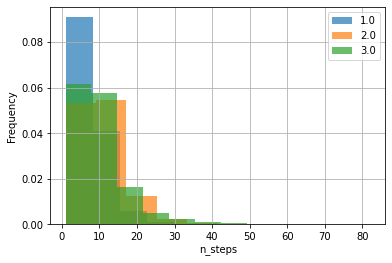

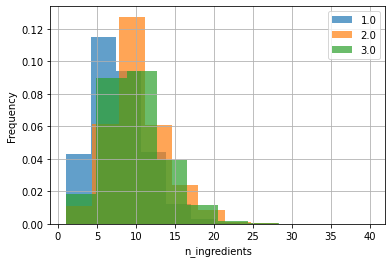

In [84]:
fig,ax = plt.subplots()
for i, data_small in data.groupby('duration_label'):
    data_small['n_steps'].hist(density=True, alpha=0.7, ax=ax, label=i)
ax.legend()
ax.set_xlabel('n_steps')
ax.set_ylabel('Frequency')

fig,ax = plt.subplots()
for i, data_small in data.groupby('duration_label'):
    data_small['n_ingredients'].hist(density=True, alpha=0.7, ax=ax, label=i)
ax.legend()
ax.set_xlabel('n_ingredients')
ax.set_ylabel('Frequency')

<AxesSubplot:xlabel='n_steps', ylabel='n_ingredients'>

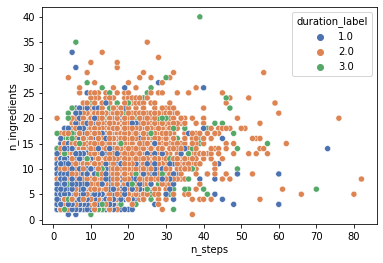

In [5]:
numeric_data = data[['n_steps', 'n_ingredients', 'duration_label']]

y = data['duration_label']

sns.scatterplot(data=numeric_data, x="n_steps", y="n_ingredients", hue="duration_label", palette="deep")

## Part 1: Single model training and evaluation

## Part 2: Classifier combination training and evaluation